In [2]:
%matplotlib widget
import copy
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.transform import Rotation as R
from tqdm.notebook import tqdm

In [3]:
'''Defining functions and HCP symmetry'''

slip_systems = np.genfromtxt('Ti-Hex_slipSystems.csv', dtype='float', delimiter=',', skip_header=1)
slip_family = np.genfromtxt('Ti-Hex_slipSystems.csv', dtype='str', delimiter=',', skip_header=1)[:,0]
n = slip_systems[:,1:4]
s = slip_systems[:,4:7]
o = np.zeros(s.shape)

pri = slip_family=='Prismatic'
bas = slip_family=='Basal'
pyr = slip_family=='Pyramidal'

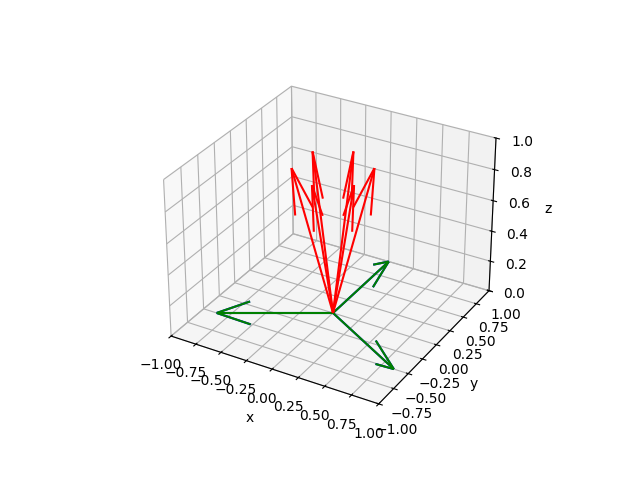

In [4]:

''' Checking slip systems'''

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(o[pri][:,0],o[pri][:,1],o[pri][:,2],s[pri][:,0],s[pri][:,1],s[pri][:,2],
          color='blue')
ax.quiver(o[bas][:,0],o[bas][:,1],o[bas][:,2],s[bas][:,0],s[bas][:,1],s[bas][:,2],
          color='green')
ax.quiver(o[pyr][:,0],o[pyr][:,1],o[pyr][:,2],s[pyr][:,0],s[pyr][:,1],s[pyr][:,2],
          color='red')

ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-0,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [4]:
'''Defining functions'''
# slip plane normal vectors for each slip system (3x prismatic, 3x basal, 6x pyramidal)
n = np.array([
    [1.0, 0.0, 0.0],
    [0.5, 0.866025, 0.0],
    [-0.5, 0.866025, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.846046, 0.0, 0.53311],
    [0.423023, 0.732697, 0.53311],
    [-0.423023, 0.732697, 0.53311],
    [-0.846046, 0.0, 0.53311],
    [-0.423023, -0.732697, 0.53311],
    [0.423023, -0.732697, 0.53311]])

# slip direction vectors for each slip system (3x prismatic, 3x basal, 6x pyramidal)
s = np.array([
    [0.0, 1.0, 0.0],
    [0.866025, -0.5, 0.0],
    [-0.866025, -0.5, 0.0],
    [0.866025, -0.5, 0.0],
    [0.0, 1.0, 0.0],
    [-0.866025, -0.5, 0.0],
    [0.296076, -0.170939, 0.939744],
    [0.296076, 0.170939, 0.939744],
    [0.0, 0.341879, 0.939744],
    [-0.296076, 0.170939, 0.939744],
    [-0.296076, -0.170939, 0.939744],
    [0.0, -0.341879, 0.939744]])

# only including prismatic and basal slip...
n = n[np.logical_or(slip_family=='Prismatic',slip_family=='Basal')]
s = s[np.logical_or(slip_family=='Prismatic',slip_family=='Basal')]

angles = np.arange(0,360,60) 
rots_c = R.from_euler('z',angles,degrees=True) # 6 rotations about c axis TODO(check this)
inv = R.from_quat([0,0,0,-1])
SYMS = list(rots_c) + [inv*r for r in rots_c] # full 12 operations including inverse

def misori(r1,r2):
    '''Calculates misorientation angle between two HCP orientations.'''
    delta = r2*r1.inv()
    mis_list = [(sym*delta).magnitude() for sym in SYMS]
    return min(mis_list)


def p(dE,T):
    '''Probability of swap using Metropolis probability function.'''
    if dE <= 0: # downhill: always accept
        return 1.0

    if T == 0: # uphill at T=0: never accept (DONT NEED SINCE T!=0)
        return 0.0

    x = dE / T
    if x > 700: # np.exp(700) is near overflow for float64
        return 0.0

    return np.exp(-x)

# ------------------------------------------------------------------------------------------------------
# def neighbour_table(N):
#     '''Creates a table of neighbours for each node.'''
#     # set offsets as up/down/left/right/front/back
#     offsets = [[0,0,1],[0,0,-1],[1,0,0],[-1,0,0],[0,1,0],[0,-1,0]]
#     idx = np.arange(N**3).reshape((N,N,N)) # node indices arranged into a cube
#     nbrs = [[] for i in range(N**3)]
#     for x in range(N):
#         for y in range(N):
#             for z in range(N):
#                 here = idx[x,y,z]
#                 for dx,dy,dz in offsets:
#                     i,j,k = x+dx, y+dy, z+dz
#                     if 0<=i<N and 0<=j<N and 0<=k<N: # check out of bounds
#                         nbrs[here].append(idx[i,j,k]) # append valid neighbour ids
#     return [np.array(n,dtype=np.int32) for n in nbrs]
# ------------------------------------------------------------------------------------------------------

def neighbour_table(N):
    """Creates a table of 6-neighbours for each node on an N*N*N grid with periodic boundaries."""
    # up,down,left,right,front,back
    offsets = [( 0,  0,  1),
               ( 0,  0, -1),
               ( 1,  0,  0),
               (-1,  0,  0),
               ( 0,  1,  0),
               ( 0, -1,  0)]

    idx = np.arange(N**3).reshape((N, N, N), order='F')
    nbrs = [[] for _ in range(N**3)]

    for x in range(N):
        for y in range(N):
            for z in range(N):
                here = idx[x, y, z]
                for dx, dy, dz in offsets:
                    # wrap each coordinate mod N
                    i = (x + dx) % N
                    j = (y + dy) % N
                    k = (z + dz) % N
                    nbrs[here].append(idx[i, j, k])

    return [np.array(n, dtype=np.int32) for n in nbrs]



def local_misorientation(oris, node, nbrs):
    '''
    Calculates the total misorientation angle in radians from a node to all its neighbours.
    Inputs:
        - oris: list of scipy orientation objects
        - node: index of node
        - nbrs: list of neighbours indices
    Output:
        - Sum of misorientation angles (rad)
    '''
    r1 = oris[node] 
    misori_sum = 0
    for nb in nbrs[node]: # loop through each neighbour, add misorientation
        r2 = oris[nb]
        misori_sum += misori(r1,r2)
    
    return misori_sum


def global_misorientation(oris, nbrs):
    '''
    Calculates the global energy. Run once before annealing loop.
    Inputs:
        - oris: list of scipy orientation objects
        - nbrs: list of neighbour indices for each node
    Outputs:
        - Sum of all misorientation angles (rad)
    '''
    global_sum = 0
    for node in range(len(oris)):
        global_sum += local_misorientation(oris, node, nbrs)
    
    return global_sum/2 # correct for double up on each neighbour pair

def m_prime(r1, r2, n, s):
    '''
    Calculate the Luster-Morris parameter m' between two orientations, given a list of slip systems.
    Inputs:
        - r1: orientation A
        - r2: orientation B
        - n: array of normal vectors for each slip system
        - s: array of direction vectors for each slip system
    Outputs:
        - 
    m' = (nA.nB)(sA.sB), where n and s are unit normal and direction vectors

    '''
    mPrimes = []
    nAs = r1.apply(n)
    sAs = r1.apply(s)
    nBs = r2.apply(n)
    sBs = r2.apply(s)

    for a in range(len(n)): # needs to be a better way of writing this...
        for b in range(len(n)):
            mPrime = np.dot(nAs[a],nBs[b]) * np.dot(sAs[a],sBs[b])
            mPrimes.append(mPrime)
    
    return max(mPrimes)

def local_mPrime(oris, node, nbrs):
    '''
    Calculates the sum of m' values across all of a node's neighbours.
    Inputs:
        - oris: list of all scipy orientation objects
        - node: index of node
        - nbrs: list of neighbours indices
    Outputs:
        - Sum of m' values
    '''
    r1 = oris[node]
    mPrime_sum = 0
    for nb in nbrs[node]:
        # for each neighbour, loop through ALL pairs of slip systems.
        r2 = oris[nb] # retrives orientation object for neighbour
        mPrime_sum += m_prime(r1, r2, n, s)

    return mPrime_sum



def global_mPrime(oris, nbrs):
    global_sum = 0
    for node in range(len(oris)):
        global_sum += local_mPrime(oris,node,nbrs)
    
    return global_sum/2 # correct for double up on each neighbour pair





In [5]:
def anneal(N, steps=10_000,T0=1.5, maximise=False, seed=42, energy_function='mPrime', num_frames=60):
    '''
    **Performs a simulated anneal on a orientations of a microstructure.**

    ## Inputs
    - N: number of nodes per dimension. Total number will be N**3
    - steps: number of steps (swaps) performed by the algorithm
    - T0: ~1.5 for mPrime and ~12 for misorientation
    - maximise: maximise or minimise the energy function
    - seed: seed for random generators
    - energy_function: 
        - 'mPrime' = sum of m' values with neighbours
        - 'misorientation' = sum of misorientation angles

    ## Returns
    - Final state (list of N**3 orientations reshaped to (N,N,N))
    - Steps vector
    - Energy vector
    
    '''
    # Assumes n and s are already defined as the list of slip normals and directions

    # # ---------- Defining Parameters ----------
    # if energy_function=='mPrime':
    #     # T0 = 1.5 based on 80% acceptance
    #     T0 = 3
    # elif energy_function=='misorientation':
    #     # T0 = 12 based on 80% acceptance
    #     T0 = 12
    
    Tf = 0.01 * T0 # near final temperature, metropolis probability of uphill is low.
    alpha = (Tf/T0)**(1/steps)

    T = T0
    rng = np.random.default_rng(seed)
    oris = R.random(N**3,rng=rng)
    nbrs = neighbour_table(N)
    E_history = np.empty(steps,dtype=float)
    T_history = np.empty(steps,dtype=float)
    dE_history = np.empty(steps,dtype=float)
    P_history = np.empty(steps,dtype=float)

    oris_frames = [copy.deepcopy(oris)]
    snapshot_steps = np.round(np.linspace(1,steps, num_frames)) # steps to take snapshot at

    if energy_function=='mPrime':
        E_total = global_mPrime(oris,nbrs)
    elif energy_function=='misorientation':
        E_total = global_misorientation(oris,nbrs)
    

    # main anneal loop
    for step in range(steps):
        a = rng.integers(0,N**3) # choose a random node
        b = rng.choice(nbrs[a]) # choose one of its neighbours
        

        if energy_function=='mPrime':
            Ea1 = local_mPrime(oris,a,nbrs)
            Eb1 = local_mPrime(oris,b,nbrs)
            oris[[a,b]] = oris[[b,a]] # swap
            Ea2 = local_mPrime(oris,a,nbrs)
            Eb2 = local_mPrime(oris,b,nbrs)
            dE = (Ea2+Eb2)-(Ea1+Eb1) # neighbour boundary double up cancels out


        if energy_function=='misorientation':
            Ea1 = local_misorientation(oris,a,nbrs)
            Eb1 = local_misorientation(oris,b,nbrs)
            oris[[a,b]] = oris[[b,a]] # swap
            Ea2 = local_misorientation(oris,a,nbrs)
            Eb2 = local_misorientation(oris,b,nbrs)
            dE = (Ea2+Eb2)-(Ea1+Eb1)

        if maximise:
            dE = -dE
        
        if rng.random() < p(dE,T): # accept a swap based on metropolis algorithm
            if maximise:
                E_total += -dE
            else:
                E_total += dE
        else:
            oris[[a,b]] = oris[[b,a]] # revert the swap

        if step in snapshot_steps:
            oris_frames.append(copy.deepcopy(oris))

        E_history[step] = E_total
        T_history[step] = T
        dE_history[step] = dE
        P_history[step] = p(dE,T)
        T *= alpha

    steps_vector = np.arange(0,steps)

    output = {"oris":oris,              # orientations
              "steps":steps_vector,     # steps
              "nbrs":nbrs,              # neighbours
              "E":E_history,            # E
              "T":T_history,            # T
              "dE":dE_history,          # dE
              "P":P_history,            # P
              "frames":oris_frames}     # orientation snapshot frames
    
    return output

In [7]:
N = 10
steps = 5000
T0 = 3
output_min = anneal(N,steps,T0=T0,seed=1)
output_max = anneal(N,steps,T0=T0, maximise=True, seed=1)
# N=5 with 10,000 steps takes 10.8 seconds


/home/espr0005/PhD/Projects/Sandbox/MisorientationSimulatedAnneal/.venv/lib/python3.12/site-packages/ipympl/backend_nbagg.py:335: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.figure.savefig(buf, format='png', dpi='figure')


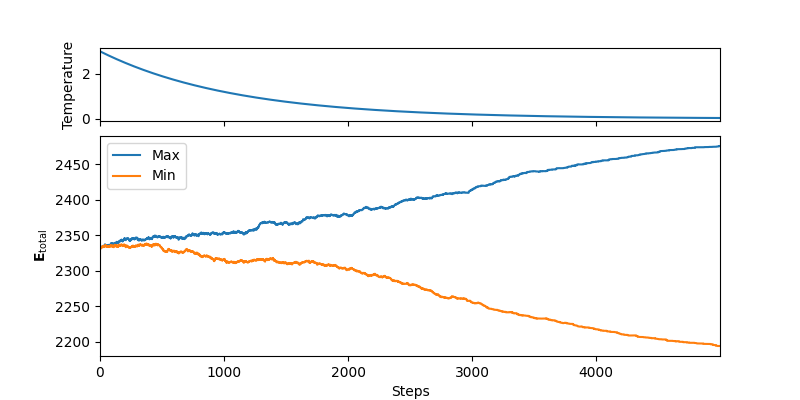

In [8]:
mosaic = [['Temp'],
          ['Energy']]

fig, ax = plt.subplot_mosaic(
    mosaic,
    figsize=(8,4),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3],
                 'hspace': 0.1},
    layout='tight'
)

# Plot as before
ax['Energy'].plot(output_max['steps'], output_max['E'], label='Max')
ax['Energy'].plot(output_min['steps'], output_min['E'], label='Min')
ax['Energy'].set_xlabel('Steps')
ax['Energy'].set_ylabel(r"$\mathbf{E}_{\mathrm{total}}$")
ax['Energy'].legend()
ax['Temp'].plot(output_min['steps'],output_min['T'])

# Top plot tweaks
ax['Temp'].set_ylabel('Temperature')
# ax['Temp'].tick_params(labelbottom=False)
#ax['Temp'].set_xticks([])

# All x‐limits
for name in ax:
    ax[name].set_xlim(0, max(output_min['steps']))

plt.show()

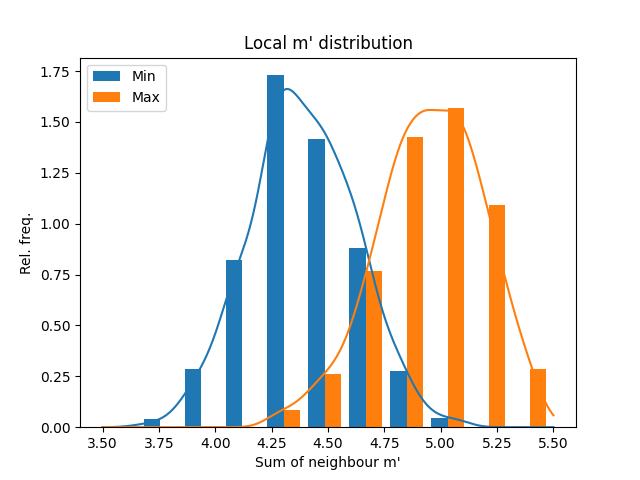

In [9]:
mp_min = np.empty(len(output_min['oris']))
mp_max = np.empty(len(output_max['oris']))

for i in range(len(output_min['oris'])):
    mp_min[i] = local_mPrime(output_min['oris'],i,output_min['nbrs'])
    mp_max[i] = local_mPrime(output_max['oris'],i,output_max['nbrs'])

# mps = [np.transpose(mp_min), np.transpose(mp_max)]
mps = [mp_min, mp_max]

kde_min = stats.gaussian_kde(mp_min)
kde_max = stats.gaussian_kde(mp_max)
xx = np.linspace(3.5,5.5,1000)

fig,ax = plt.subplots()

h = ax.hist(mps, 10, density=True, histtype='bar', label=['Min','Max'])
ax.plot(xx, kde_min(xx), color='tab:blue')
ax.plot(xx, kde_max(xx), color='tab:orange')
ax.legend(loc='upper left')
ax.set_xlabel("Sum of neighbour m'")
ax.set_ylabel("Rel. freq.")
ax.set_title("Local m' distribution")

plt.show()
    

In [8]:
def plot_anneal(output_min, output_max):
    mosaic = [['T', 'h'],
            ['E', 'h']]

    fig, ax = plt.subplot_mosaic(
        mosaic,
        figsize = (8,4),
        gridspec_kw={
            'height_ratios': [1, 3],
            'hspace': 0.05,
            'wspace': 0.05}
        )
    # Temperature over time
    ax['T'].plot(output_max['steps'], output_min['T'], color='tab:gray')
    ax['T'].set_ylabel('T')
    ax['T'].set_xticks([])

    # Energy over time
    ax['E'].plot(output_min['steps'], output_min['E'], label='Min')
    ax['E'].plot(output_max['steps'], output_max['E'], label='max')

    # Histogram
    kde_min = stats.gaussian_kde(mp_min)
    kde_max = stats.gaussian_kde(mp_max)
    xx = np.linspace(3.5,5.5,1000)
    ax['h'].hist(mps, 10, density=True, histtype='bar', label=['Min', 'Max'])
    ax['h'].plot(xx,kde_min(xx), color='tab:blue')
    ax['h'].plot(xx,kde_max(xx), color='tab:orange')
    ax['h'].yaxis.tick_right()
    ax['h'].set_yticks([0,0.5,1,1.5])
    # ax['h'].set_xlabel('Local m\'')


    plt.show()

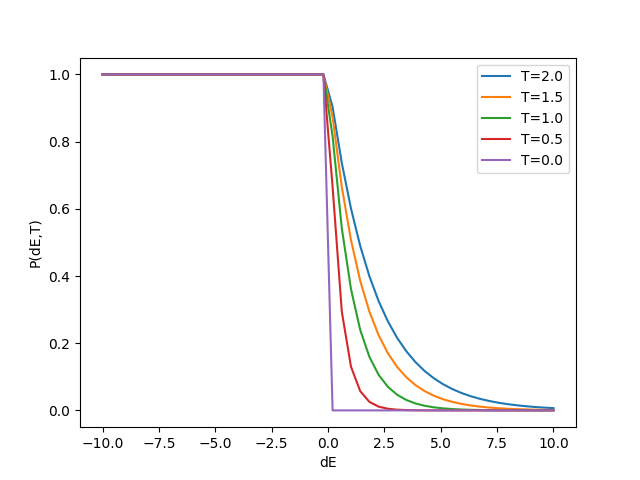

In [11]:
# probabilitiy function

fig,ax = plt.subplots()

dE_list = np.linspace(-10,10)
T_list = np.arange(2,-0.5,-0.5)

for T in T_list:
    dE_list = -dE_list
    P = [p(dE,T) for dE in dE_list]
    ax.plot(dE_list, P, label=f'T={str(T)}')

ax.legend()
ax.set_xlabel('dE')
ax.set_ylabel('P(dE,T)')
plt.show()

In [12]:
'''Testing steps'''

# steps_list = np.arange(1000,20001,2000)
# N = 5
# plots_x = []
# plots_y = []

# for i in tqdm(range(len(steps_list))):
#     run = anneal(8,steps=steps_list[i],T0=2, seed=None)
#     plots_x.append(run['steps'])
#     plots_y.append(run['E'])

'Testing steps'

In [13]:
# fig,ax = plt.subplots(layout='tight')
# for i in range(len(plots_x)):
#     ax.plot(plots_x[i],plots_y[i], label=f'{steps_list[i]/1000:.0f}k')
#     ax.text(plots_x[i][-1],plots_y[i][-1],f'{steps_list[i]/1000:.0f}k')
# ax.legend(frameon=False)
# ax.set_xlim((0,20000))
# ax.set_xlabel('Steps', fontsize=14)
# ax.set_ylabel('E sum(m\')')
# plt.show()

In [14]:

# temp_list = np.arange(0.2,3.1,0.2)
# N = 5
# plots_x = []
# plots_y = []

# for i in tqdm(range(len(temp_list))):
#     run = anneal(8,steps=10000,T0=temp_list[i], seed=None)
#     plots_x.append(run['steps'])
#     plots_y.append(run['E'])

In [15]:

# fig,ax = plt.subplots(layout='tight')
# for i in range(len(plots_x)):
#     ax.plot(plots_x[i],plots_y[i], label=f'{temp_list[i]:.1f}')
#     # ax.text(plots_x[i][-1],plots_y[i][-1],f'{steps_list[i]/1000:.0f}k')
# ax.legend(frameon=False)
# # ax.set_xlim((0,20000))
# ax.set_xlabel('Steps', fontsize=14)
# ax.set_ylabel('E sum(m\')')
# plt.show()

In [16]:
# num_sims = 10
# N = 5
# plots_x = []
# plots_y = []
# oris_list = []

# for i in tqdm(range(num_sims)):
#     run = anneal(8,steps=10000,T0=0.8, seed=None)
#     plots_x.append(run['steps'])
#     plots_y.append(run['E'])
#     oris_list.append(run['oris'])

In [17]:

# fig,ax = plt.subplots(layout='tight')
# for i in range(len(plots_x)):
#     ax.plot(plots_x[i],plots_y[i], label=f'{i}')
#     # ax.text(plots_x[i][-1],plots_y[i][-1],f'{steps_list[i]/1000:.0f}k')
# ax.legend(frameon=False)
# # ax.set_xlim((0,20000))
# ax.set_xlabel('Steps', fontsize=14)
# ax.set_ylabel('E sum(m\')')
# plt.show()

### Optimal parameters: N=8, mPrime
**Temperature**: 0.8 - 1.2

**Steps**: 10,000 more steps is better... 

In [6]:
# Make an animation for the minimising and maximising.

N = 8
steps = 10000
T0 = 1.0

A = anneal(N,steps=steps,T0=T0)
B = anneal(N,steps=steps,T0=T0, maximise=True)

NameError: name 'mp_min' is not defined

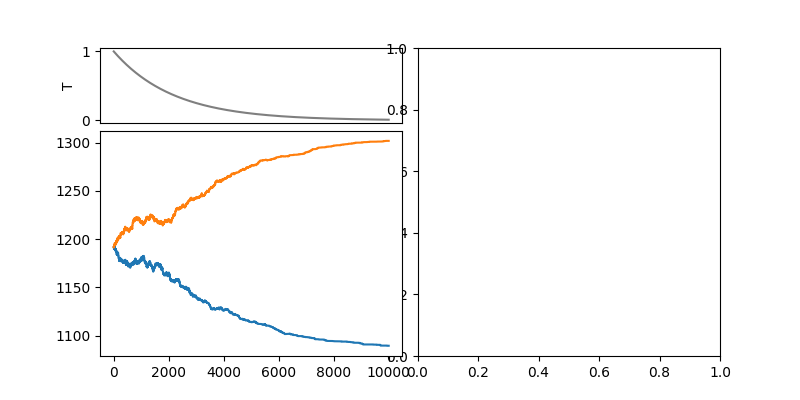

In [9]:
plot_anneal(A,B)

In [36]:
plotter = pv.Plotter(off_screen=True, window_size=(600,600))
plotter.open_movie("anim_min.mp4", framerate=15, quality=8)

actor = None
for i, frame in enumerate(A['frames']):
    
    grid = pv.ImageData()
    grid.dimensions = [N+1,N+1,N+1],  # need to add since using cells
    grid.origin = (0,0,0)
    grid.spacing = (1,1,1)

    mp = [ local_mPrime(frame,node,A['nbrs']) for node,_ in enumerate(frame)]
    grid.cell_data['values'] = mp

    if actor is None:
        actor = plotter.add_mesh(
            grid,
            scalars="values",
            cmap="inferno",
            clim = (4,5.5),
            show_scalar_bar=True
        )
        plotter.view_vector((1,1,1))
    else:
        actor.mapper.SetInputData(grid)

    plotter.add_text(f"sum(m\') = {sum(mp):.0f}", name="framenum")
    plotter.write_frame()
    plotter.remove_actor("framenum")

plotter.close()

'''
Reducing sum(m') is the same as maximising incompatibility...
'''

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


"\nReducing sum(m') is the same as maximising incompatibility...\n"

In [ ]:
# make the fsam1-3 and fsam21-3 txt files using the ORIS

# A ------------------------------------------
with open("CoeffsA/fsam1.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[0,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsA/fsam2.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[1,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsA/fsam3.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[2,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsA/fsam21.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[0,1]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsA/fsam22.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[1,1]
        f.write(f"{coeff:f}"+"\n")
with open("CoeffsA/fsam23.txt", "w") as f:
    for i in range(len(A['oris'])):
        coeff = A['oris'][i].as_matrix()[1,2]
        f.write(f"{coeff:f}"+"\n")


# B ------------------------------------------
with open("CoeffsB/fsam1.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[0,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsB/fsam2.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[1,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsB/fsam3.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[2,0]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsB/fsam21.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[0,1]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsB/fsam22.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[1,1]
        f.write(f"{coeff:f}"+"\n")

with open("CoeffsB/fsam23.txt", "w") as f:
    for i in range(len(B['oris'])):
        coeff = B['oris'][i].as_matrix()[1,2]
        f.write(f"{coeff:f}"+"\n")


# feat and phase ...